In [24]:
from PIL import Image, ImageOps, ImageFilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [25]:
from PIL import Image, ImageOps, ImageFilter
from sklearn.model_selection import train_test_split
import numpy as np
import os
from tqdm import tqdm

def read_image(base_folder: str, image_size: tuple[int, int]) -> tuple[np.array, np.array]:
    X = []
    y = []
    for label in os.listdir(base_folder):
        label_folder = os.path.join(base_folder, label)
        print(f"Currently reading {label_folder}")
        for image_name in tqdm(os.listdir(label_folder)):
            if image_name.split('.')[-1] in ('jpg', 'png', 'gif'):
                image_path = os.path.join(label_folder, image_name)
                image = Image.open(image_path)
                image = image.convert('L')
                image = image.resize(image_size)
                X.append(image)
                y.append(label)
    X = np.array([np.array(x) for x in X])
    y = np.array(y)
    return (X, y)

# Read images and labels
X, y = read_image("Model Datasets", (128, 128))




Currently reading Model Datasets\A


100%|██████████| 200/200 [00:08<00:00, 23.10it/s]


Currently reading Model Datasets\C


100%|██████████| 200/200 [00:09<00:00, 22.00it/s]


Currently reading Model Datasets\E


100%|██████████| 200/200 [00:16<00:00, 12.08it/s]


In [26]:

def apply_contrast_stretching(X):
    # Apply contrast stretching
    min_intensity = np.percentile(X, 5)
    max_intensity = np.percentile(X, 95)
    stretched_X = np.clip((X - min_intensity) / (max_intensity - min_intensity) * 255, 0, 255)
    return stretched_X.astype(np.uint8)

def apply_adaptive_threshold(X):
    # Apply adaptive thresholding
    blurred_image = X.filter(ImageFilter.GaussianBlur(radius=2))
    thresholded_image = blurred_image.point(lambda p: p > 128 and 255)
    return thresholded_image


In [27]:
# Apply contrast stretching to each image
X_stretched = np.array([apply_contrast_stretching(image) for image in X])


In [28]:

# Apply adaptive thresholding to each image
X_thresholded = np.array([apply_adaptive_threshold(Image.fromarray(image)) for image in X_stretched])

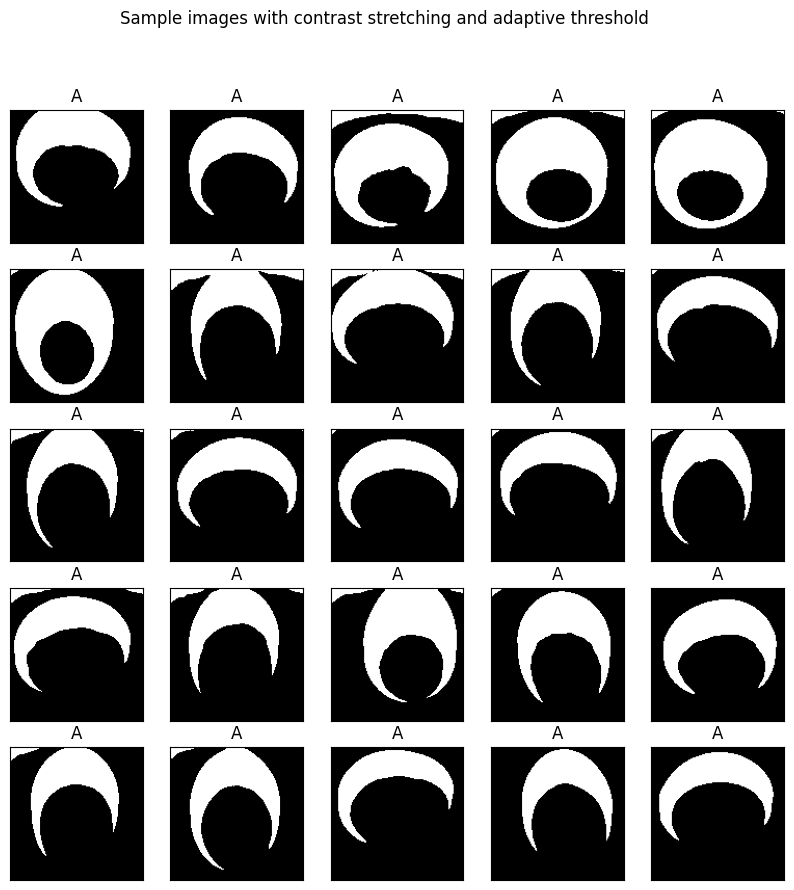

In [29]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Sample images with contrast stretching and adaptive threshold')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_thresholded[i], cmap='binary')  # Use 'binary' colormap for binary images
    plt.title(y[i])
plt.show()

In [30]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [31]:


# Assuming X_thresholded contains Sobel edge-detected images and y contains labels

# Reshape Sobel edge-detected images to a flat 1D array for each sample
X_flattened = X_thresholded.reshape(X_thresholded.shape[0], -1)

# Initialize StratifiedKFold with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=74)

# Lists to store results from each fold
accuracy_list = []
classification_reports = []

# Perform 10-fold cross-validation
for fold_num, (train_index, test_index) in enumerate(skf.split(X_flattened, y), start=1):
    X_train_fold, X_test_fold = X_flattened[train_index], X_flattened[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Train the classifier on the training data
    rf_classifier.fit(X_train_fold, y_train_fold)

    # Predict on the test data
    y_pred_fold = rf_classifier.predict(X_test_fold)

    # Calculate accuracy for each fold
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_list.append(accuracy_fold)

    # Print the classification report for each fold
    classification_report_fold = classification_report(y_test_fold, y_pred_fold, digits=4)
    classification_reports.append(classification_report_fold)
    print(f"Fold {fold_num} - Classification Report:\n{classification_report_fold}\n")

# Calculate and print the mean accuracy
mean_accuracy = np.mean(accuracy_list)
print(f"Mean Accuracy Across Folds: {mean_accuracy:.4f}")

# Calculate and print the mean classification report
mean_classification_report = np.mean([np.array([float(x) for x in report.split()[-4:]]) for report in classification_reports], axis=0)
print("Mean Classification Report:")
print(f"Precision: {mean_classification_report[0]:.4f}")
print(f"Recall:    {mean_classification_report[1]:.4f}")
print(f"F1-Score:  {mean_classification_report[2]:.4f}")
print(f"Support:   {mean_classification_report[3]:.4f}")


Fold 1 - Classification Report:
              precision    recall  f1-score   support

           A     0.8333    1.0000    0.9091        20
           C     1.0000    0.8500    0.9189        20
           E     0.9474    0.9000    0.9231        20

    accuracy                         0.9167        60
   macro avg     0.9269    0.9167    0.9170        60
weighted avg     0.9269    0.9167    0.9170        60


Fold 2 - Classification Report:
              precision    recall  f1-score   support

           A     0.9500    0.9500    0.9500        20
           C     0.8421    0.8000    0.8205        20
           E     0.8095    0.8500    0.8293        20

    accuracy                         0.8667        60
   macro avg     0.8672    0.8667    0.8666        60
weighted avg     0.8672    0.8667    0.8666        60


Fold 3 - Classification Report:
              precision    recall  f1-score   support

           A     1.0000    0.9500    0.9744        20
           C     0.9048    0.95

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report


In [33]:

# Assuming X_thresholded contains Sobel edge-detected images and y contains labels

# Reshape Sobel edge-detected images to a flat 1D array for each sample
X_flattened = X_thresholded.reshape(X_thresholded.shape[0], -1)

# Initialize StratifiedKFold with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create a Random Forest classifier
svm_classifier = SVC(random_state=74)

# Lists to store results from each fold
accuracy_list = []
classification_reports = []

# Pesvmorm 10-fold cross-validation
for fold_num, (train_index, test_index) in enumerate(skf.split(X_flattened, y), start=1):
    X_train_fold, X_test_fold = X_flattened[train_index], X_flattened[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Train the classifier on the training data
    svm_classifier.fit(X_train_fold, y_train_fold)

    # Predict on the test data
    y_pred_fold = svm_classifier.predict(X_test_fold)

    # Calculate accuracy for each fold
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_list.append(accuracy_fold)

    # Print the classification report for each fold
    classification_report_fold = classification_report(y_test_fold, y_pred_fold, digits=4)
    classification_reports.append(classification_report_fold)
    print(f"Fold {fold_num} - Classification Report:\n{classification_report_fold}\n")

# Calculate and print the mean accuracy
mean_accuracy = np.mean(accuracy_list)
print(f"Mean Accuracy Across Folds: {mean_accuracy:.4f}")

# Calculate and print the mean classification report
mean_classification_report = np.mean([np.array([float(x) for x in report.split()[-4:]]) for report in classification_reports], axis=0)
print("Mean Classification Report:")
print(f"Precision: {mean_classification_report[0]:.4f}")
print(f"Recall:    {mean_classification_report[1]:.4f}")
print(f"F1-Score:  {mean_classification_report[2]:.4f}")
print(f"Support:   {mean_classification_report[3]:.4f}")


Fold 1 - Classification Report:
              precision    recall  f1-score   support

           A     0.9524    1.0000    0.9756        20
           C     0.9524    1.0000    0.9756        20
           E     1.0000    0.9000    0.9474        20

    accuracy                         0.9667        60
   macro avg     0.9683    0.9667    0.9662        60
weighted avg     0.9683    0.9667    0.9662        60


Fold 2 - Classification Report:
              precision    recall  f1-score   support

           A     0.9524    1.0000    0.9756        20
           C     0.9000    0.9000    0.9000        20
           E     0.9474    0.9000    0.9231        20

    accuracy                         0.9333        60
   macro avg     0.9332    0.9333    0.9329        60
weighted avg     0.9332    0.9333    0.9329        60


Fold 3 - Classification Report:
              precision    recall  f1-score   support

           A     1.0000    0.9500    0.9744        20
           C     0.9500    0.95

In [34]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import numpy as np


In [35]:


# Assuming X_edges_rgb_stretched_rgb_sobel contains Sobel edge-detected images and y contains labels

# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Reshape Sobel edge-detected images to a flat 1D array for each sample
X_flattened = X_thresholded.reshape(X_thresholded.shape[0], -1)

# Initialize StratifiedKFold with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create a Random Forest classifier
xgb_classifier = XGBClassifier()


# Lists to store results from each fold
accuracy_list = []
classification_reports = []

# Pexgborm 10-fold cross-validation
for fold_num, (train_index, test_index) in enumerate(skf.split(X_flattened, y), start=1):
    X_train_fold, X_test_fold = X_flattened[train_index], X_flattened[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Train the classifier on the training data
    xgb_classifier.fit(X_train_fold, y_train_fold)

    # Predict on the test data
    y_pred_fold = xgb_classifier.predict(X_test_fold)

    # Calculate accuracy for each fold
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_list.append(accuracy_fold)

    # Print the classification report for each fold
    classification_report_fold = classification_report(y_test_fold, y_pred_fold, digits=4)
    classification_reports.append(classification_report_fold)
    print(f"Fold {fold_num} - Classification Report:\n{classification_report_fold}\n")

# Calculate and print the mean accuracy
mean_accuracy = np.mean(accuracy_list)
print(f"Mean Accuracy Across Folds: {mean_accuracy:.4f}")

# Calculate and print the mean classification report
mean_classification_report = np.mean([np.array([float(x) for x in report.split()[-4:]]) for report in classification_reports], axis=0)
print("Mean Classification Report:")
print(f"Precision: {mean_classification_report[0]:.4f}")
print(f"Recall:    {mean_classification_report[1]:.4f}")
print(f"F1-Score:  {mean_classification_report[2]:.4f}")
print(f"Support:   {mean_classification_report[3]:.4f}")


Fold 1 - Classification Report:
              precision    recall  f1-score   support

           0     0.8571    0.9000    0.8780        20
           1     0.9048    0.9500    0.9268        20
           2     0.9444    0.8500    0.8947        20

    accuracy                         0.9000        60
   macro avg     0.9021    0.9000    0.8999        60
weighted avg     0.9021    0.9000    0.8999        60


Fold 2 - Classification Report:
              precision    recall  f1-score   support

           0     0.9000    0.9000    0.9000        20
           1     0.8947    0.8500    0.8718        20
           2     0.9048    0.9500    0.9268        20

    accuracy                         0.9000        60
   macro avg     0.8998    0.9000    0.8995        60
weighted avg     0.8998    0.9000    0.8995        60


Fold 3 - Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9500    0.9744        20
           1     0.9048    0.95